# Evaluation script for the paper: "Segmentation CNNs are denoising models"

Authors:
* Luis A. Zavala Mondragón
* Ruud van Sloun
* Peter de With 
* Fons van der Sommen

Loading the necessary libraries

In [1]:
%matplotlib inline
import os
import h5py

In [2]:
dataset = "/media/s152030/Data drive/datasets/BRATS_2/BRATSmini5_train.h5"

from scripts_analysis.dataLoaderAndTestEval import dataDummy 
#from scripts_analysis.evalMetrics import Jaccard, diceScore
from scripts_analysis.figures import impulseResponses, iRplotCol, figureSegmSlices, impRes
from scripts_analysis.tables import generateTableResults, generateTVspread

from scripts_analysis.figures import irSegRec

In [3]:
    
# Getting the patient numbers
iDlist = []
with h5py.File(dataset, 'r' ) as f:
    keys = list(f.keys())
    for k in keys:
        # First split is patient iD
        iD = k.split("_")[0]
        if iD in iDlist:
            pass
        else:
            iDlist.append(iD)

Npat = len(iDlist)
test_list = iDlist[2*Npat//3:-1]



test_data = dataDummy(dataset, test_list)
test_data_blur = dataDummy(dataset, test_list, blur=True)
test_data_noise = dataDummy(dataset, test_list, noise=True)
test_data_rot = dataDummy(dataset, test_list, rotate=True, angle=15)

In [4]:
from CNNs.SUM import SUM_2d

from CNNs.unet import unet_2d
from CNNs.unet_noBN import unet_2d as unetNoBN_2d

# U-Net parameters
wf = 8
depth = 4
in_chans= 1

SUMrec = SUM_2d(in_chans, depth, wf).float().cuda()
SUMseg = SUM_2d(in_chans, depth, wf).float().cuda()
SUMdeno = SUM_2d(in_chans, depth, wf).float().cuda()
SUMsegNA = SUM_2d(in_chans, depth, wf).float().cuda()
uNet = unet_2d(in_chans, depth, wf*2).float().cuda()
uNetNoBN = unetNoBN_2d(in_chans, depth, wf*2).float().cuda()


SUMparams = [in_chans, depth, wf]
UNetParams = [in_chans, depth, wf*2]

## Experiment 1:  Signal processing behavior of U-Net-like models


This experiment relies on the information displayed on Table 1 and Table 2 in Appendix E

#### Figure 2 and Figure 8.

Figure 3 employs whichSample=3, while Figure 8 uses whichSample=251

#### Figure 2. A slice of the test set processed with the SUMSeg, SUMEst, U-Net and U-NetNoBN models. In the figure, column Input displays the input to each of the models. Column Lin. ED. (EDS(α=0)(·)) refers to the output of the encoder-decoder module when the bias of the nonlinearities is set to zero. Column Inp. sig. O.L. is the input signal to the output layer. Finally, the last two columns (Est. segmentation and True segmentation) show the estimated and true segmentation masks, respectively. For display, images in the columns Lin. ED. (EDS(α=0)(·) and Inp. sig. O.L. are scaled in such way that the similarity with the input image is more visible. Finally, it should be noted that the Reconstruction signal is missing in the U-Net models, this signal has been excluded, because these models are too complex to be analyzed. Appendix F, shows the segmentations an additional subject

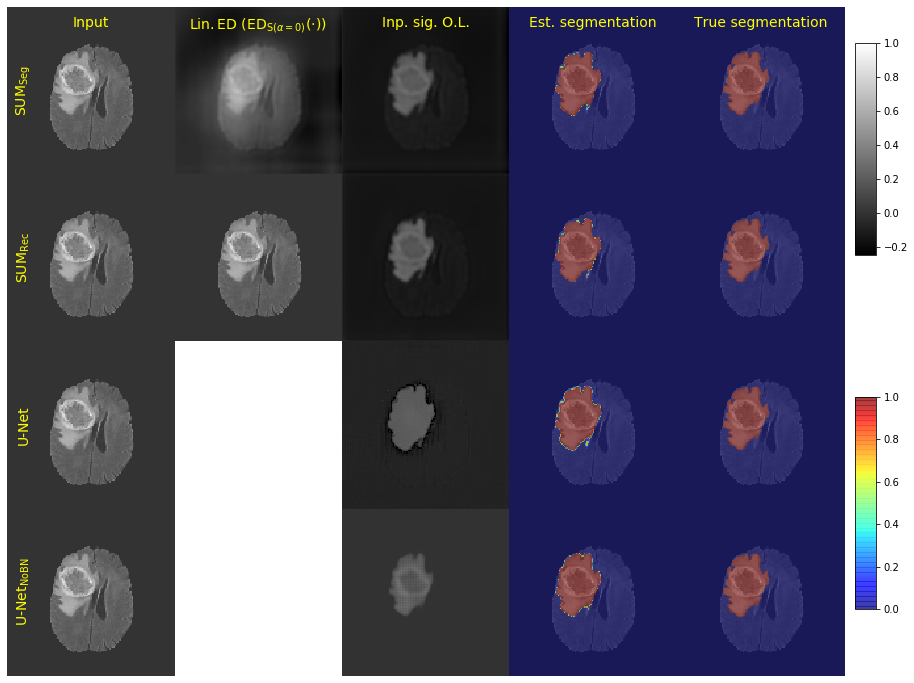

In [5]:
from scripts_analysis.figures import figure1

run = 4
whichSample = 3

figure1(SUM_2d, unet_2d, unetNoBN_2d, SUMparams, UNetParams, run, test_data, whichSample=whichSample)

### Table 1 and Table 2

#### Table 1. Dice score and intersection over union (IoU) measured over the segmentation estimates generated by the U-Net, U-NetNoBN, SUMSeg and SUMRec models. The performance values are obtained by averaging the performance after 5 training cycles.

In [6]:
from scripts_analysis.tables import table1DiceIoU

no_runs = 5
print("Models evaluated in undistorted data")
table1DiceIoU(SUM_2d, unet_2d, unetNoBN_2d, SUMparams, UNetParams, uNetNoBN, test_data, no_runs)

# These are extensions of Table 1 that are shown in Table 2 in Appendix E
print()
print("Models evaluated in blured data")
table1DiceIoU(SUM_2d, unet_2d, unetNoBN_2d, SUMparams, UNetParams, uNetNoBN, test_data_blur, no_runs)
print()
print("Models evaluated in noisy data")
table1DiceIoU(SUM_2d, unet_2d, unetNoBN_2d, SUMparams, UNetParams, uNetNoBN, test_data_noise, no_runs) 

Models evaluated in undistorted data
Metric & U-Net & U-Net$_\mathrm{NoBN}$ & SUM$_\mathrm{Seg}$ & SUM$_\mathrm{Rec}$ \\
Dice Score & 0.884 $\pm$ 0.004 & 0.859 $\pm$ 0.006 & 0.849 $\pm$ 0.010 & 0.859 $\pm$ 0.007 \\
IoU & 0.793 $\pm$ 0.007 & 0.752 $\pm$ 0.009 & 0.738 $\pm$ 0.015 & 0.752 $\pm$ 0.010 \\

Models evaluated in blured data
Metric & U-Net & U-Net$_\mathrm{NoBN}$ & SUM$_\mathrm{Seg}$ & SUM$_\mathrm{Rec}$ \\
Dice Score & 0.793 $\pm$ 0.018 & 0.852 $\pm$ 0.005 & 0.841 $\pm$ 0.007 & 0.854 $\pm$ 0.005 \\
IoU & 0.657 $\pm$ 0.024 & 0.742 $\pm$ 0.008 & 0.726 $\pm$ 0.011 & 0.745 $\pm$ 0.007 \\

Models evaluated in noisy data
Metric & U-Net & U-Net$_\mathrm{NoBN}$ & SUM$_\mathrm{Seg}$ & SUM$_\mathrm{Rec}$ \\
Dice Score & 0.553 $\pm$ 0.102 & 0.778 $\pm$ 0.063 & 0.780 $\pm$ 0.039 & 0.805 $\pm$ 0.012 \\
IoU & 0.389 $\pm$ 0.101 & 0.641 $\pm$ 0.083 & 0.641 $\pm$ 0.051 & 0.674 $\pm$ 0.017 \\


#### Figure 3.  Impulse responses of the encoder-decoder model within the SUMSeg and SUMRec CNNs for one of the training cycles. The first row (Imp. response) depicts the impulse response of the SUMSeg and SUMRec models, respectively. The second row (Freq. response) shows the magnitude of the Fourier transform of the impulse response. It can be noted that the frequency response of the SUMSeg model focuses on a narrower frequency range that is more focused in the lower and intermediate frequency ranges. In contrast, filters of the SUMRec propagate more frequencies.


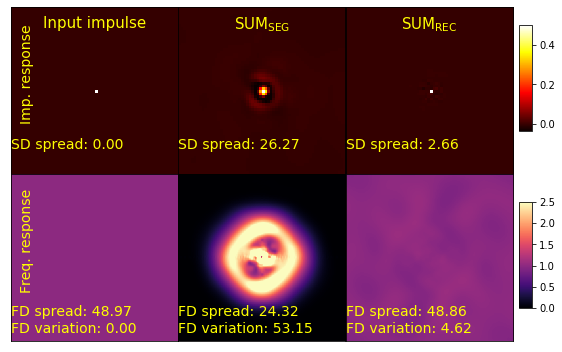

In [7]:
from scripts_analysis.figures import irSegRec

r = 0
weightPaths = [
    "./CNN_weights/SUM_SEG_run%s.pyt"%r,
    "./CNN_weights/SUM_REC_run%s.pyt"%r]
modelNames = [
    "$\mathregular{SUM_{SEG}}$",
    "$\mathregular{SUM_{REC}}$"]
figureName = "results/ir_run%s.pdf"%r

irSegRec(SUM_2d, SUMparams, weightPaths, modelNames, figureName)

## Experiment 2: Contrasting impulse response of model trained for segmentation and denoising

#### Figure 5. Comparison between the operation of a SUM model trained for image segmentation (top) and denoising (bottom). In column (Lin. ED (EDS(α=0)(·))), it can be observed that the convolution filters of the encoder and decoder of the segmentation model can reconstruct a blurred version of the input. In contrast, the model trained for image denosing, is able to propagate more frequencies and it is even able to reconstruct the noise. When the non-linearities are enabled (column Inp. sig O.L.), the encoder-decoder module within the SUM trained for image segmentation attenuates the non-anomalous areas and sends them to the negative image range. In a similar process, the model trained for image denosing suppresses the noise, while preserving the signal of interest. Finally, the output layer of both models scale the signal, and in the case of the segmentation model, the signal is saturated.

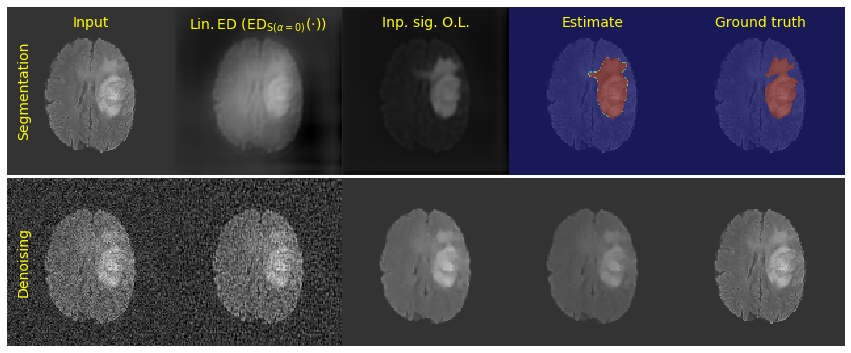

In [8]:
# Figure-only parameters


whichSubject= 3 #3 #67 #251 #21 #3#67#61#73#61#21#3#9

run = 4

SUMsegWeights = "./CNN_weights/SUM_SEG_run%s.pyt"%run
SUMdenoWeights = "./CNN_weights/SUM_DENO.pyt"
modelNamesFig = ['Segmentation','Denoising']
fname = "results/denoVsSeg.pdf"
whichSubject = 89



from scripts_analysis.figures import  figure5
   
figure5(SUM_2d, SUMparams, SUMsegWeights, SUMdenoWeights, modelNamesFig, whichSubject, test_data, fname)

#### Figure 4.  Impulse responses of a SUM model trained for image segmentation and denoising. Note that the model trained for seg-mentation has a wider response in space and it reconstructs less frequency bands. In contrast, the model trained for image denoising has a more localized impulse response and its frequency response is broader.

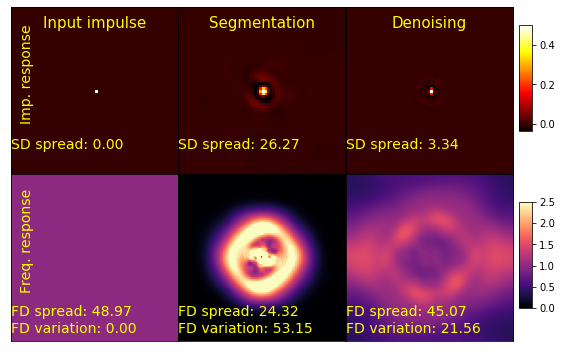

In [9]:
r = 0
weightPaths = [
    "./CNN_weights/SUM_SEG_run%s.pyt"%r,
    "./CNN_weights/SUM_DENO.pyt"]

modelNames = [
    "Segmentation",
    "Denoising"]
figureName = "results/ir_denoSeg%s.pdf"%r

irSegRec(SUM_2d, SUMparams, weightPaths, modelNames, figureName)

## Appendices

### Appendix H: Effect of the weight decay in the impulse response of the SUMSeg model

#### Table 3. Dice score and intersection over union (IoU) measured for segmentation estimates produced by the SEG model with different data augmentation techniques.

In [10]:
from scripts_analysis.tables import tableDiceIoU_weightDecay
    
no_runs = 5
tableDiceIoU_weightDecay(SUM_2d, [in_chans, depth, wf], test_data, no_runs)
print()
tableDiceIoU_weightDecay(SUM_2d, [in_chans, depth, wf], test_data_blur, no_runs)
print()
tableDiceIoU_weightDecay(SUM_2d, [in_chans, depth, wf], test_data_noise, no_runs)

W.D. val. & 0.5 & 0.25 & 0.125 & 0.075 & 0 \\
Dice Sc. & 0.828 $\pm$ 0.002 & 0.835 $\pm$ 0.002 & 0.840 $\pm$ 0.006 & 0.839 $\pm$ 0.003 & 0.843 $\pm$ 0.007 \\
IoU & 0.707 $\pm$ 0.004 & 0.717 $\pm$ 0.004 & 0.725 $\pm$ 0.009 & 0.723 $\pm$ 0.005 & 0.729 $\pm$ 0.010 \\
SDS & 23.4 $\pm$ 1.86 & 25.8 $\pm$ 1.95 & 27.5 $\pm$ 0.98 & 28.1 $\pm$ 0.57 & 30.0 $\pm$ 1.36 \\
FDV & 44.8 $\pm$ 3.66 & 57.5 $\pm$ 5.06 & 70.1 $\pm$ 3.46 & 71.3 $\pm$ 7.39 & 88.0 $\pm$ 4.10 \\
FDS & 24.5 $\pm$ 0.93 & 25.7 $\pm$ 1.24 & 26.0 $\pm$ 1.11 & 24.9 $\pm$ 2.11 & 24.6 $\pm$ 1.70 \\

W.D. val. & 0.5 & 0.25 & 0.125 & 0.075 & 0 \\
Dice Sc. & 0.825 $\pm$ 0.003 & 0.830 $\pm$ 0.002 & 0.830 $\pm$ 0.005 & 0.826 $\pm$ 0.004 & 0.828 $\pm$ 0.006 \\
IoU & 0.702 $\pm$ 0.004 & 0.709 $\pm$ 0.003 & 0.710 $\pm$ 0.007 & 0.704 $\pm$ 0.006 & 0.706 $\pm$ 0.009 \\
SDS & 23.4 $\pm$ 1.86 & 25.8 $\pm$ 1.95 & 27.5 $\pm$ 0.98 & 28.1 $\pm$ 0.57 & 30.0 $\pm$ 1.36 \\
FDV & 44.8 $\pm$ 3.66 & 57.5 $\pm$ 5.06 & 70.1 $\pm$ 3.46 & 71.3 $\pm$ 7.39 & 88.

#### Figure 9. Impulse response for SUM models trained with different data augmentations. The top row depicts the impulse response, while the bottom row shows their corresponding Fourier spectrums.

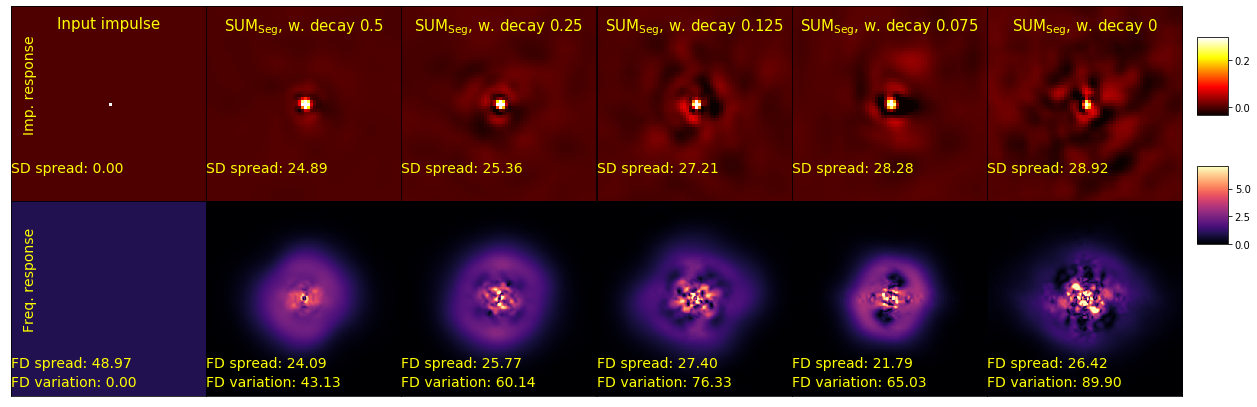

In [11]:
from scripts_analysis.figures import ablationStudyWeightDecay 

wDVals = [0.5, 0.25, 0.125, 0.075, 0]
ablationStudyWeightDecay(SUM_2d, SUMparams, test_data, whichSubject, wDVals)

### Appendix G:  Impulse responses of the SUM model as a function of data augmentation

#### Table 3. Dice score and intersection over union (IoU) measured for segmentation estimates produced by the SEG model with different data augmentation techniques

In [12]:
from scripts_analysis.tables import tableDiceIoU_Augmentations
    
no_runs = 5
tableDiceIoU_Augmentations(SUM_2d, SUMparams, test_data, no_runs)
print()
print()
tableDiceIoU_Augmentations(SUM_2d, SUMparams, test_data_blur, no_runs)
print()
print()
tableDiceIoU_Augmentations(SUM_2d, SUMparams, test_data_noise, no_runs)

Augment. & No augmentation & Rotations & Noise & Blur & Rot. noise and blur \\
Dice Sc. & 0.709 $\pm$ 0.086 & 0.849 $\pm$ 0.010 & 0.833 $\pm$ 0.003 & 0.833 $\pm$ 0.003 & 0.852 $\pm$ 0.003 \\
IoU & 0.556 $\pm$ 0.103 & 0.738 $\pm$ 0.015 & 0.713 $\pm$ 0.005 & 0.714 $\pm$ 0.005 & 0.742 $\pm$ 0.005 \\
FDS & 25.9 $\pm$ 0.88 & 26.8 $\pm$ 2.30 & 28.2 $\pm$ 2.47 & 26.8 $\pm$ 1.57 & 30.0 $\pm$ 2.75 \\
FDV & 53.9 $\pm$ 3.47 & 53.0 $\pm$ 2.12 & 55.2 $\pm$ 3.54 & 56.1 $\pm$ 0.88 & 50.9 $\pm$ 4.12 \\
FDS & 25.8 $\pm$ 0.52 & 23.6 $\pm$ 0.68 & 22.3 $\pm$ 0.71 & 23.8 $\pm$ 1.32 & 21.4 $\pm$ 1.37 \\


Augment. & No augmentation & Rotations & Noise & Blur & Rot. noise and blur \\
Dice Sc. & 0.695 $\pm$ 0.089 & 0.841 $\pm$ 0.007 & 0.828 $\pm$ 0.004 & 0.831 $\pm$ 0.003 & 0.849 $\pm$ 0.003 \\
IoU & 0.540 $\pm$ 0.106 & 0.726 $\pm$ 0.011 & 0.707 $\pm$ 0.005 & 0.711 $\pm$ 0.005 & 0.737 $\pm$ 0.004 \\
FDS & 25.9 $\pm$ 0.88 & 26.8 $\pm$ 2.30 & 28.2 $\pm$ 2.47 & 26.8 $\pm$ 1.57 & 30.0 $\pm$ 2.75 \\
FDV & 53.9 $\p

#### Figure 9.  Impulse response for SUM models trained with different data augmentations. The top row depicts the impulse response, while the bottom row shows their corresponding Fourier spectrums.

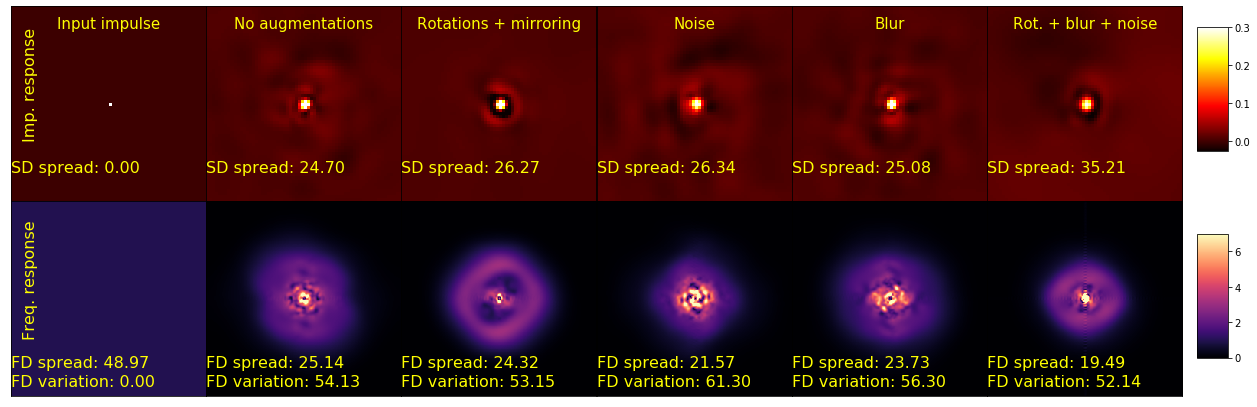

In [13]:
from scripts_analysis.figures import impulRespAug
    
impulRespAug(SUM_2d, SUMparams, r=0)